# Lab 5: Wide & Deep Networks

### *Harrison Noble & Henry Lambson*

***

__Dataset Selection__

For this lab, we will be switching the dataset we have been using for table data. In our previous table data labs, we used the wine quality dataset. However, this lab requires that our dataset needs at least 2 categorical features and the wine quality dataset only contains 1 categorical feature.

Our new dataset is the HR Analytics Case Study dataset (Kaggle) which contains many features about 4410 employees. The classification task for this dataset is to determine if an employee is going to quit or stay at the company (binary classification). This dataset is seperated into many different files, these files include: general employee data (24 features such as age, distance from home, education level, etc.), employee survey data (satisfaction levels, etc.), and manager surveys about the employees (performance rating and involvement). This dataset also has two files containing a timeseries of when the employee clocked in and when they clocked out over a 262 day period. This timeseries data is most likely going to be transformed into an "average time spent working" feature for each employee. 

The dataset can be found here: https://www.kaggle.com/vjchoudhary7/hr-analytics-case-study [1]

***

## 1 Preparation

### 1.1 Define & Prepare Class Variables

Below is our code that loads our dataset, removing any data that is unneeded, scales the data, and encodes the data.

In [2]:
#some data prep code taken from https://www.kaggle.com/artyomkolas/hr-analytics-2 [2]
#code taken will be referenced using the '[2]' comment
import pandas as pd

#read all csv files
general_data = pd.read_csv('general_data.csv')
empl_survey = pd.read_csv('employee_survey_data.csv')
mngr_survey = pd.read_csv('manager_survey_data.csv')
in_time = pd.read_csv('in_time.csv')
out_time = pd.read_csv('out_time.csv')

#concatenate dataframes other than time series data (join on EmployeeID)
#--------------- (All code below taken from [2]) #---------------
df = pd.concat([general_data.set_index('EmployeeID'), 
                empl_survey.set_index('EmployeeID'),
                mngr_survey.set_index('EmployeeID')], 
               axis=1, 
               join='inner').reset_index()

#create avg clock in/out time, avg work day, and number of days off feature from time data
weekends = ['2015-12-25', '2015-10-02', '2015-11-11', '2015-05-01', '2015-01-14', 
            '2015-11-10', '2015-03-05', '2015-07-17', '2015-01-26', '2015-11-09', 
            '2015-09-17', '2015-01-01']
#first do the in time
in_time.iloc[:,1:] = in_time.iloc[:,1:].astype('datetime64[ns]')
in_time.rename({'Unnamed: 0': 'EmployeeID'}, axis=1, inplace=True)
in_time.drop(weekends, axis=1, inplace=True)
df_in = pd.DataFrame()
for col in in_time.columns[1:]:
    time = pd.DatetimeIndex(in_time[col])
    df_in[col] = (time.hour * 60 + time.minute)/60
    
#now do the out time
out_time.iloc[:,1:] = out_time.iloc[:,1:].astype('datetime64[ns]')
out_time.rename({'Unnamed: 0': 'EmployeeID'}, axis=1, inplace=True)
out_time.drop(weekends, axis=1, inplace=True)
df_out = pd.DataFrame()
for col in in_time.columns[1:]:
    time = pd.DatetimeIndex(out_time[col])
    df_out[col] = (time.hour * 60 + time.minute)/60
    
#create new features and concatenate dataframes together
df_time = pd.DataFrame()
df_time['EmployeeID'] = in_time['EmployeeID']
df_time['in_avg'] = df_in.iloc[:, 1:].mean(axis=1)
df_time['out_avg'] = df_out.iloc[:,1:].mean(axis=1)
df_time['avg_work_day'] = df_time['out_avg'] - df_time['in_avg']
df_time['num_day_off'] = df_in.isnull().sum(axis=1)
df =  pd.concat([df.set_index('EmployeeID'), 
                 df_time.set_index('EmployeeID')],
                axis=1, 
                join='inner').reset_index()
df.reset_index(drop=True, inplace=True)
#--------------- (All code above taken from [2]) #---------------

In the above code block, we load each CSV file into a seperate dataframe. We then concatenate these dataframes together using the shared EmployeeID column in order to get one dataframe to work with. Next, we process the clock in and clock out dataframes in order to calculate the average time the employee clocks in and out along with their average work day, and number of days off. Finally, we create a temporary dataframe to hold the values for these columns and then concatenate it to the large dataframe.  

In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

#drop all rows with NA values
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

#drop all columns with uneeded (features with 1 unique value and EmployeeID) data
df.drop([c for c in list(df) if len(df[c].unique()) <= 1], inplace=True, axis=1)
df.drop(['EmployeeID'], inplace=True, axis=1)

#code taken from [2]
integer  = ['TotalWorkingYears', 'EnvironmentSatisfaction', 'JobSatisfaction', 
            'WorkLifeBalance', 'NumCompaniesWorked']
for col in integer:
    df[[col]] = df[[col]].astype('int64')
#------------------

#normalize all continuous data
continuous = ['Age', 'DistanceFromHome', 'MonthlyIncome', 'NumCompaniesWorked',
              'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear',
              'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
              'in_avg', 'out_avg', 'avg_work_day', 'num_day_off']
std_scaler = StandardScaler()
df[continuous] = std_scaler.fit_transform(df[continuous])
    
#for every object datatype, encode as integer
categorical = df.select_dtypes(include='object').columns
for col in df.select_dtypes(include='object').columns:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])
    
#show df
pd.set_option('display.max_columns', None)
df

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,in_avg,out_avg,avg_work_day,num_day_off
0,1.538800,0,2,2,-0.394993,2,1,0,1,0,1,1.405193,-0.677226,-1.149725,0,-1.320442,2.483520,-0.980272,-0.677926,-1.159067,3,4,2,3,3,0.136450,-0.242485,-0.244367,0.777304
1,-0.648079,1,1,1,0.099071,1,1,0,1,6,2,-0.492557,-1.077952,2.126858,1,-0.678523,0.157924,-0.329582,-0.368371,-0.037179,3,2,4,2,4,-0.670422,0.000711,0.009780,0.049269
2,-0.538735,0,1,1,0.963683,4,4,1,4,7,1,2.725773,-0.677226,-0.057531,3,-0.806907,-0.617274,-0.329582,-0.677926,-0.317651,2,2,1,3,3,1.307262,-0.494769,-0.512525,-1.042783
3,0.117329,0,0,1,-0.889057,5,1,1,3,1,1,0.385846,0.124225,-1.149725,3,0.220163,1.708321,0.158435,1.488960,0.243293,4,4,3,2,3,-1.012510,-0.393523,-0.379885,0.231278
4,-0.538735,0,2,1,0.099071,1,3,1,1,7,2,-0.885202,0.524950,-0.876677,2,-0.293372,-0.617274,-0.166910,-0.677926,-0.037179,4,1,3,3,3,-0.200165,0.223081,0.225822,-1.588808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4295,-0.866767,0,2,2,-0.642025,3,4,0,2,1,2,-0.630737,-0.677226,0.761615,0,-0.678523,-0.617274,-0.166910,-0.368371,0.243293,3,4,3,2,3,-0.103183,-0.305294,-0.303943,-1.224791
4296,0.554704,0,2,1,-0.518509,4,3,0,1,6,2,-0.101400,0.124225,0.488567,1,-0.164988,1.708321,-0.654927,-0.677926,-0.598123,4,1,3,3,3,1.231685,0.628083,0.611515,-1.224791
4297,-0.866767,0,2,1,-0.889057,4,3,1,1,2,0,-0.813561,-0.276501,-0.057531,0,-0.164988,-0.617274,-0.654927,-0.677926,-0.598123,4,4,3,2,3,0.232493,-1.196274,-1.199597,-0.860774
4298,-1.304143,0,2,1,1.951811,2,1,1,2,7,1,-0.596086,-1.077952,1.307712,0,-0.806907,0.933123,-0.492255,-0.368371,-0.598123,1,3,3,3,4,-1.125802,-0.010801,0.004426,0.959313


In this block, we clean the data by dropping all instances that contain any null values, dropped all columns with only one unique value since they will have no use to us, and drop the EmployeeID column because it has no use as it is an arbitrary number. We then convert TotalWorkingYears, EnvironmentSatisfaction, JobSatisfaction, WorkLifeBalance, and NumCompaniesWorked from floats to ints because they are all whole numbers. We did this so that we could use StandardScalar to normalize all columns with continuous values, and make all categorical columns ints. Finally, we encoded all columns with categorical data to ints. 

As we can see in the table above, this is what our data looks like before adding crossed categorical features. The Attrition column is our classification task. Attrition signifies if the employee quit (1) or if the employee stayed at the company (0).

In [4]:
#rename 'Attrition' column to 'Quit' (0 = didn't quit, 1 = quit)
df.rename(columns={'Attrition': 'Quit'}, inplace=True)

#save quit column as y
y = df.Quit
#drop quit column from df and save as X
X = df.drop(['Quit'], axis=1)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4300 entries, 0 to 4299
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4300 non-null   float64
 1   BusinessTravel           4300 non-null   int64  
 2   Department               4300 non-null   int64  
 3   DistanceFromHome         4300 non-null   float64
 4   Education                4300 non-null   int64  
 5   EducationField           4300 non-null   int64  
 6   Gender                   4300 non-null   int64  
 7   JobLevel                 4300 non-null   int64  
 8   JobRole                  4300 non-null   int64  
 9   MaritalStatus            4300 non-null   int64  
 10  MonthlyIncome            4300 non-null   float64
 11  NumCompaniesWorked       4300 non-null   float64
 12  PercentSalaryHike        4300 non-null   float64
 13  StockOptionLevel         4300 non-null   int64  
 14  TotalWorkingYears       

As shown here, all columns contain no null values, the prediction task (Attrition/Quit) is no longer in the dataframe, and all of our columns are either normalized or encoded, perfect for a deep learning model. Every column that is an int is a categorical feature, and every column that is a float is a normalized continuous feature. 

### 1.2 Identify Features That Should Be Combined Into Cross-Product Features

Below is our code to combine categorical features into cross-product features. Our selected categorical features can be seen in the ```cross_cols``` list. 

In [8]:
import numpy as np

cross_cols = [['JobLevel', 'StockOptionLevel'],
              ['EnvironmentSatisfaction', 'JobSatisfaction', 'JobInvolvement'],
              ['PerformanceRating', 'JobInvolvement'],
              ['Education', 'JobLevel'],
              ['BusinessTravel', 'JobLevel']]

cross_col_df_names = []
for col_list in cross_cols:
    enc = LabelEncoder()
    #X_cross = X[col_list].apply(lambda val: print(type(val)), axis=1)
    X_cross = X[col_list].astype(str)
    X_cross = X_cross.apply(lambda val: '_'.join(val), axis=1)
    cross_col_name = '_'.join(col_list)

    enc.fit(X_cross.to_numpy())

    X[cross_col_name] = enc.transform(X_cross)
    
    cross_col_df_names.append(cross_col_name)

for cross in cross_col_df_names:
    print(len(X[cross].unique()))
    
cross_col_df_names

20
64
8
25
15


['JobLevel_StockOptionLevel',
 'EnvironmentSatisfaction_JobSatisfaction_JobInvolvement',
 'PerformanceRating_JobInvolvement',
 'Education_JobLevel',
 'BusinessTravel_JobLevel']

In [9]:
X

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,in_avg,out_avg,avg_work_day,num_day_off,JobLevel_StockOptionLevel,EnvironmentSatisfaction_JobSatisfaction_JobInvolvement,PerformanceRating_JobInvolvement,Education_JobLevel,BusinessTravel_JobLevel
0,1.538800,2,2,-0.394993,2,1,0,1,0,1,1.405193,-0.677226,-1.149725,0,-1.320442,2.483520,-0.980272,-0.677926,-1.159067,3,4,2,3,3,0.136450,-0.242485,-0.244367,0.777304,0,46,2,5,10
1,-0.648079,1,1,0.099071,1,1,0,1,6,2,-0.492557,-1.077952,2.126858,1,-0.678523,0.157924,-0.329582,-0.368371,-0.037179,3,2,4,2,4,-0.670422,0.000711,0.009780,0.049269,1,37,5,0,5
2,-0.538735,1,1,0.963683,4,4,1,4,7,1,2.725773,-0.677226,-0.057531,3,-0.806907,-0.617274,-0.329582,-0.677926,-0.317651,2,2,1,3,3,1.307262,-0.494769,-0.512525,-1.042783,15,22,2,18,8
3,0.117329,0,1,-0.889057,5,1,1,3,1,1,0.385846,0.124225,-1.149725,3,0.220163,1.708321,0.158435,1.488960,0.243293,4,4,3,2,3,-1.012510,-0.393523,-0.379885,0.231278,11,61,1,22,2
4,-0.538735,2,1,0.099071,1,3,1,1,7,2,-0.885202,0.524950,-0.876677,2,-0.293372,-0.617274,-0.166910,-0.677926,-0.037179,4,1,3,3,3,-0.200165,0.223081,0.225822,-1.588808,2,50,2,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4295,-0.866767,2,2,-0.642025,3,4,0,2,1,2,-0.630737,-0.677226,0.761615,0,-0.678523,-0.617274,-0.166910,-0.368371,0.243293,3,4,3,2,3,-0.103183,-0.305294,-0.303943,-1.224791,4,45,1,11,11
4296,0.554704,2,1,-0.518509,4,3,0,1,6,2,-0.101400,0.124225,0.488567,1,-0.164988,1.708321,-0.654927,-0.677926,-0.598123,4,1,3,3,3,1.231685,0.628083,0.611515,-1.224791,1,50,2,15,10
4297,-0.866767,2,1,-0.889057,4,3,1,1,2,0,-0.813561,-0.276501,-0.057531,0,-0.164988,-0.617274,-0.654927,-0.677926,-0.598123,4,4,3,2,3,0.232493,-1.196274,-1.199597,-0.860774,0,61,1,15,10
4298,-1.304143,2,1,1.951811,2,1,1,2,7,1,-0.596086,-1.077952,1.307712,0,-0.806907,0.933123,-0.492255,-0.368371,-0.598123,1,3,3,3,4,-1.125802,-0.010801,0.004426,0.959313,4,10,6,6,11


We decided to cross-product features that we believed would be related to one another. We think that JobLevel and StockOptionLevel will be highly correlated because the higher your position, the more stock options you would have. EvironmentSatisfaction JobSatisfaction go hand in hand, and changes in one will most likely affect the other. We also believe that JobInvolvement should be crossed with these two because the more an employee enjoys their work, the more involved they will be. Performance Rating and JobInvolvement are also likely to be correlated, as if an employee is not involved with their job, they are likely to recieve a poor performance rating. Education and JobLevel are crossed because for the most part, the better your education, the better the job you will get. Finally, we believe BusinessTravel and JobTravel could be related but we want to explore this to see if there is a correlation between high job level and high travel and how it will affect our deep learning model.  

As we can see from the integers output above, we have 20 different values for JobLevel/StockOption feature cross, 64 different values for EnvironmentSatisfaction/JobSatisfaction/JobInvolvement feature cross, 8 different values for PerformanceRating/JobInvolvement feature cross, 25 different values for Education/JobLevel feature cross, and finally, 15 different values for BusinessTravel/JobLevel feature cross. 

### 1.3 Evaluation Metric(s)

We decided to use the F1-score evaluation metric because our dataset has a large imbalance in our target classes. As we can see below, only ~16% of the data contains employees who quit, while the other ~84% are employees who stayed with the company. Accuracy would be a poor measurement for this dataset, since by just guessing stay, the model would be correct 84% of the time. F1-score takes into account the class imbalance to give us an accurate reading of how well the model performs in our binary classification task.       

Ratio of quit to total employees: 16.16
Number of instances in each class: [3605  695]


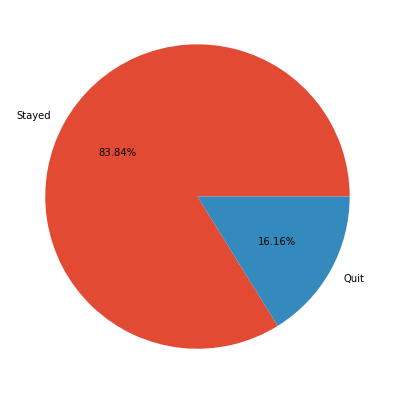

In [16]:
from sklearn.metrics import make_scorer, f1_score
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

f1_scorer = make_scorer(f1_score)

print(f"Ratio of quit to total employees: %.2f" % (len(y[y == 1])/len(y) * 100))
print('Number of instances in each class:',np.bincount(y))

fig = plt.figure(figsize=(7, 7))
plt.pie(np.bincount(y), labels=['Stayed', 'Quit'], autopct='%.2f%%')
plt.show()

F1-score is suited well for our business case because the majority of the time, employers collecting data on their employees on whether they quit or not, is going to be an imbalanced dataset.

### 1.4 Method For Dividing Dataset Into Training & Testing

For dividing our dataset into training and testing sets, we decided to use Stratified K-Fold cross validation. In our instance, we decided to use 6 folds since (as we can see above) the number of employees who quit compared to total employees is about 16% and we want each split to have around the same ratio as the whole dataset (100/6 = 16.66...). By choosing Stratified K-Fold we make sure to preserve the overall percentage of classes in each fold. Since our dataset is relatively small and imbalanced, we want to use Stratified K-Fold over regular K-Fold (our research on this method found at [3]).

We think this cross validation method is a realistic mirroring of how an algorithm would be used in practice because small businesses won't have access to their employee data of this scale (according to [4], small businesses make up 99.9% of all businesses in the US and a great majority of them only have 1-19 employees). Since K-Fold cross validation is good for small datasets and Stratified K-Fold is good for imbalanced small datasets, small businesses attempting to create a machine learning model of this nature would most likely be using Stratified K-Fold methods for splitting their data. 

In [23]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=1)

try:
    X = X.to_numpy()
    y = y.to_numpy()
except:
    pass #already numpy arrays

for train_idx, test_idx in cv.split(X, y):
    y_train, y_test = y[train_idx], y[test_idx]
    print('Number of instances in train set broken down by class:', 
          np.bincount(y_train), 
          'and test set:', 
          np.bincount(y_test))

Number of instances in train set broken down by class: [3004  579] and test set: [601 116]
Number of instances in train set broken down by class: [3004  579] and test set: [601 116]
Number of instances in train set broken down by class: [3004  579] and test set: [601 116]
Number of instances in train set broken down by class: [3004  579] and test set: [601 116]
Number of instances in train set broken down by class: [3004  580] and test set: [601 115]
Number of instances in train set broken down by class: [3005  579] and test set: [600 116]


Looking at the above output, we can see that there are about 3004 employees who stayed and 579 employees who quit for each training set. The testing set contains around 601 employees who stayed and 116 employees who quit. By doing the math, we can see that both the training and testing sets for each fold contain about 16% employees who quit and 84% employees who stayed, which is comparable to our dataset as a whole:

$\frac{597}{(3304 + 579)} = 0.1615$

$\frac{116}{(601 + 116)} = 0.1617$

***

## 2 Modeling

### 2.1 Wide & Deep Networks

- __[2 points]__ Create at least three combined wide and deep networks to classify your data using Keras. Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations. Note: use the "history" return parameter that is part of Keras "fit" function to easily access this data.
- *Note: Show that the models converged*

### 2.2 Generalization Performance

- __[2 points]__ Investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two different number of layers. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab to select the number of layers that performs superiorly. 
- *Note: Altering number of layers counts as a new model (changing activation functions, change neurons, new feature crossings, new number of layers) select one that performs the best (statistical test)*

### 2.3 Performance Difference Between Best Wide & Deep Network & Standard MLP

- __[1 points]__ Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP). For classification tasks, use the receiver operating characteristic and area under the curve. For regression tasks, use Bland-Altman plots and residual variance calculations.  Use proper statistical method to compare the performance of different models. 
- *Note: Build MLP in Keras and compare model (use ROC curve)*

***

## 3 Exceptional Work: ...

- 5000 students: You have free reign to provide additional analyses.
- One idea __(required for 7000 level students):__ Capture the embedding weights from the deep network and (if needed) perform dimensionality reduction on the output of these embedding layers (only if needed). That is, pass the observations into the network, save the embedded weights (called embeddings), and then perform  dimensionality reduction in order to visualize results. Visualize and explain any clusters in the data.
- *Note: Capture trained embedding weights (columns of W) (may need to perform PCA) and figure out what categorical variable (one we were most interested in) is associated with it*

***

## Resources

[1] HR Analytics Case Study dataset. https://www.kaggle.com/vjchoudhary7/hr-analytics-case-study

[2] HR Analytics Case Study example notebook. https://www.kaggle.com/artyomkolas/hr-analytics-2

[3] When to use Stratified K-Fold. https://towardsdatascience.com/stratified-k-fold-what-it-is-how-to-use-it-cf3d107d3ea2#:~:text=Stratified%20kfold%20cross%20validation%20is%20typically%20useful%20when%20we%20have,is%20on%20the%20small%20side

[4] Small Business Statistics. https://smallbiztrends.com/small-business-statistics